# 00 - Prerequisites

## 00.a. Unzip CSV file

1. Unzip the 7z file. Manual task.

### 00.b - Create dir

Can be skipped if directories already exists.

In [1]:
import os

# Define the name of the directory to be created
dirs = ["data","data/in","data/out","data/out/table"]

for directory in dirs:
    if os.path.exists(directory):
        print(f"{directory} already exists")
    else:
        os.mkdir(directory)
        print(f"Directory '{directory}' created")

data already exists
data/in already exists
data/out already exists
data/out/table already exists


### 00.c - Run this to cleanup/reset the out folder

Can be skipped if some of the query execution is to be repeated.

In [44]:
import os
import shutil


file_name="trip_data"
raw_table_name="raw_trip_data_table"
enrich_table_name="enrich_trip_data_table"

parq_output_files=["data/out/"+file_name+".parquet",
                  "data/out/table/"+raw_table_name,
                  "data/out/table/"+enrich_table_name]

# Check if the directory exists
for file in parq_output_files:
    if os.path.exists(file):
        shutil.rmtree(file)
        print(f'{file} has been deleted.')
    else:
        print(f'{file} does not exist.')

data/out/table/enrich_trip_data_table does not exist.


## Reset Enrichment Layer

In [40]:
import os
import shutil
parq_output_files=["data/out/table/"+enrich_table_name]
for file in parq_output_files:
    if os.path.exists(file):
        shutil.rmtree(file)
        print(f'{file} has been deleted.')
    else:
        print(f'{file} does not exist.')

data/out/table/enrich_trip_data_table has been deleted.


### 00.d - Install shapely

In [33]:
!pip install pip install geopandas shapely

# IF ALL PREREQUISITES ARE SATISFIED, THE PROCESS STARTS HERE

### 00.d - Set common variables

In [26]:
file_name="trip_data"
raw_table_name="raw_trip_data_table"
enrich_table_name="enrich_trip_data_table"
# Query tables
query1_table_name="query1_idle_time"
query2_table_name="query2_avg_idle_time_per_borough"
query3_table_name="query3_trip_same_borough"
query4_table_name="query4_trip_diff_borough"

column_partitioner="medallion"
bucket_count=400

## 00.e - Setup Spark Session

In [27]:
from pyspark.sql import SparkSession

# This was run on a 32gb machine. Adjust the driver memory as per laptop configuration
# Utilizing more than 80% of the memory allocated causes error.
spark = SparkSession.builder \
    .appName("BDM2024 - Project01") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "12g")\
    .config("spark.memory.fraction", ".8") \
    .enableHiveSupport() \
    .config("spark.sql.warehouse.dir", "data/out/table") \
    .getOrCreate()

In [6]:
# Enable below if you are resetting the docker image too.
# This prouces a gazillion logs and you will scratch your head why are you losing so much disk space
#spark.sparkContext.setLogLevel("DEBUG")

# 01 - Prepare the data

## 1.1 Load csv files to hive table. Let's call it Raw layer

Raw Layer contains the base format of data. We only add bucketing and partitioning to it.

### 1.1.1 Spark Setup

In [7]:
# See above step

### 1.1.2. List the files to be ingested.

In [8]:
file_name="trip_data"
file_prefix="data/in/"+file_name+"_"
# List of CSV files
#csv_file_paths = [file_prefix +"test1.csv",file_prefix +"test2.csv"]
csv_file_paths = [file_prefix + "1.csv" , file_prefix + "2.csv", file_prefix + "3.csv",
                  file_prefix + "4.csv", file_prefix + "5.csv", file_prefix + "6.csv",
                  file_prefix + "7.csv", file_prefix + "8.csv", file_prefix + "9.csv",
                  file_prefix + "10.csv", file_prefix + "11.csv", file_prefix + "12.csv"]

### 1.1.3. Declare the csv file schema.

In [9]:
from pyspark.sql.functions import col,to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType

raw_file_schema= StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_time_in_secs", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])


### 1.1.4 Read the csv files

Add the persists so that the file remains to disk

In [10]:
df = spark.read.csv(csv_file_paths, header=True, schema=raw_file_schema).persist()

### 1.1.5. Create the hive table

Apply `bucketing` and `partitioning` to the table.

In [11]:

# To reset the table
spark.sql("DROP TABLE IF EXISTS "+raw_table_name)
df.withColumn("pickup_date", to_date(col("pickup_datetime")))\
    .write\
    .format("parquet")\
    .bucketBy(bucket_count,column_partitioner)\
    .partitionBy("pickup_date")\
    .sortBy("pickup_datetime")\
    .mode("append")\
    .saveAsTable(raw_table_name)
df.unpersist()    
print("Writing parquet file successful.")

Writing parquet file successful.


### 1.1.6 Sanity Checks

Check the details from the Raw Layer table

In [12]:
spark.sql("SHOW TABLES").show(truncate=False)
spark.sql("SHOW PARTITIONS "+raw_table_name).show(truncate=False)

+---------+-------------------+-----------+
|namespace|tableName          |isTemporary|
+---------+-------------------+-----------+
|default  |raw_trip_data_table|false      |
+---------+-------------------+-----------+

+----------------------+
|partition             |
+----------------------+
|pickup_date=2013-01-01|
|pickup_date=2013-01-02|
|pickup_date=2013-01-03|
|pickup_date=2013-01-04|
|pickup_date=2013-01-05|
|pickup_date=2013-01-06|
|pickup_date=2013-01-07|
|pickup_date=2013-01-08|
|pickup_date=2013-01-09|
|pickup_date=2013-01-10|
|pickup_date=2013-01-11|
|pickup_date=2013-01-12|
|pickup_date=2013-01-13|
|pickup_date=2013-01-14|
|pickup_date=2013-01-15|
|pickup_date=2013-01-16|
|pickup_date=2013-01-17|
|pickup_date=2013-01-18|
|pickup_date=2013-01-19|
|pickup_date=2013-01-20|
+----------------------+
only showing top 20 rows



## 1.2 Create the enrichment layer

Enrichment layer limits the data to what is necessary to answer the queries. It also adds any needed column for the queries so that the query does minimal computation

### 1.2.1. Read geojson file

In [59]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType, LongType, ArrayType

# https://gist.github.com/JulesBelveze/a552e8c53dfd1f46948cbeb32c096611
geojson_data="data/in/nyc-boroughs.geojson"
# Define the custom schema
geojson_schema = StructType([
    StructField("type", StringType(), nullable=True),
    StructField("id", LongType(), nullable=True),
    StructField("properties", StructType([
        StructField("boroughCode", LongType(), nullable=True),
        StructField("borough", StringType(), nullable=True),
        StructField("@id", StringType(), nullable=True)
    ]), nullable=True),
    StructField("geometry", StructType([
        StructField("type", StringType(), nullable=True),
        StructField("coordinates", ArrayType(ArrayType(ArrayType(DoubleType()))), nullable=True)
    ]), nullable=True)
])

# Read GeoJSON file with custom schema
geojson_df = spark.read.schema(geojson_schema).json(geojson_data)

### 1.2.2. Sanity check for geojson file

In [60]:
# View the schema
geojson_df.printSchema()

# Show the data
geojson_df.show()
geojson_df = geojson_df.na.drop() #remove the NULL values

# Show the resulting DataFrame
geojson_df.show()

num_rows = geojson_df.count()
print(f"Number of boroughs: {num_rows}")

root
 |-- type: string (nullable = true)
 |-- id: long (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- boroughCode: long (nullable = true)
 |    |-- borough: string (nullable = true)
 |    |-- @id: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)

+-------+----+--------------------+--------------------+
|   type|  id|          properties|            geometry|
+-------+----+--------------------+--------------------+
|   NULL|NULL|                NULL|                NULL|
|   NULL|NULL|                NULL|                NULL|
|   NULL|NULL|                NULL|                NULL|
|Feature|   0|{5, Staten Island...|{Polygon, [[[-74....|
|   NULL|NULL|                NULL|                NULL

### 1.2.4. Define needed functions

In [61]:
from pyspark.sql.functions import udf, col,expr
from shapely.geometry import shape, Point

def array_to_polygon(coordinates):
    polygon = shape({"type": "Polygon", "coordinates": coordinates})
    return polygon

def polygon_area(coordinates):
    polygon = shape({"type": "Polygon", "coordinates": coordinates})
    return polygon.area


In [62]:
spark.udf.register("array_to_polygon_udf",array_to_polygon,StructType([StructField("type", StringType()), StructField("coordinates", StringType())]))

<function __main__.array_to_polygon(coordinates)>

In [63]:
spark.udf.register("polygon_area_udf",polygon_area,DoubleType())

<function __main__.polygon_area(coordinates)>

In [64]:
# Enrich the GeoJSON DataFrame with the Shapely polygons
enriched_geojson = geojson_df.withColumn("area", expr("polygon_area_udf(geometry.coordinates)"))
enriched_geojson.printSchema()

root
 |-- type: string (nullable = true)
 |-- id: long (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- boroughCode: long (nullable = true)
 |    |-- borough: string (nullable = true)
 |    |-- @id: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)
 |-- area: double (nullable = true)



In [65]:
from pyspark.sql.functions import broadcast
from pyspark.storagelevel import StorageLevel
## here
geometry_df = geojson_df.select(
    "id",
    col("properties.boroughCode").alias("borough_code"),
    col("properties.borough").alias("borough"),
    col("geometry.coordinates").alias("coordinates")
)
geo_table_name="nyc_geo"
spark.sql("DROP TABLE IF EXISTS "+geo_table_name)
geojson_iterable = enriched_geojson.write\
    .format("parquet")\
    .mode("append")\
    .saveAsTable(geo_table_name)
geojson_iterable.show()

AttributeError: 'NoneType' object has no attribute 'show'

In [ ]:
# Define a UDF to get the borough name
def get_borough_name(lat, lon, data):
    point = Point(lon, lat)
    for row in data:
        polygon = shape({"type": "Polygon", "coordinates": row["geometry"]["coordinates"]})
        if polygon.contains(point):
            return row["properties"]["borough"]
    return ""

# Register the UDF
#get_borough_name_udf = udf(lambda lat, lon: get_borough_name(lat, lon, geojson_iterable), StringType())
spark.udf.register("get_borough_name_udf",lambda lat, lon: get_borough_name(lat, lon, geojson_iterable),StringType())

In [12]:
from pyspark.sql.functions import broadcast
from pyspark.storagelevel import StorageLevel

geojson_iterable = enriched_geojson.collect()

# Define a UDF to get the borough name
def get_borough_name(lat, lon, data):
    point = Point(lon, lat)
    for row in data:
        polygon = shape({"type": "Polygon", "coordinates": row["geometry"]["coordinates"]})
        if polygon.contains(point):
            return row["properties"]["borough"]
    return None

# Register the UDF
#get_borough_name_udf = udf(lambda lat, lon: get_borough_name(lat, lon, geojson_iterable), StringType())
spark.udf.register("get_borough_name_udf",lambda lat, lon: get_borough_name(lat, lon, geojson_iterable),StringType())

<function __main__.<lambda>(lat, lon)>

### 1.2.5 Limit data and create the `pickup_borough` and `dropoff_borough` column

In [13]:
trip_data_bucketed = spark.table(raw_table_name)
# Remove unwanted records.
# 1.Rides that are longer than 4 hours (14400 seconds)
# 2.pickup_latitude, pickup_longitude, dropoff_latitude, and dropoff_longitude that are null
# 3.any other null columns
limited_trip_data_bucketed=trip_data_bucketed \
    .where("trip_time_in_secs <= 14400 and pickup_latitude is not null and pickup_longitude is not null and dropoff_latitude is not null and dropoff_longitude is not null")\
    .persist()

In [14]:
# Select only needed columns
# Create the enrichment table
#.withColumn("pickup_borough", get_borough_name_udf(trip_data_bucketed.pickup_latitude, trip_data_bucketed.pickup_longitude))\
#.withColumn("dropoff_borough", get_borough_name_udf(trip_data_bucketed.dropoff_latitude, trip_data_bucketed.dropoff_longitude))\

spark.sql("DROP TABLE IF EXISTS "+enrich_table_name)
enriched_df = limited_trip_data_bucketed \
    .selectExpr("medallion","pickup_date","pickup_datetime","dropoff_datetime"\
    ,"get_borough_name_udf(pickup_latitude, pickup_longitude) as pickup_borough"
    ,"get_borough_name_udf(dropoff_latitude, dropoff_longitude) as pickup_borough")\
    .write\
    .format("parquet")\
    .bucketBy(bucket_count,column_partitioner)\
    .partitionBy("pickup_date")\
    .sortBy("pickup_datetime")\
    .mode("append")\
    .saveAsTable(enrich_table_name)
limited_trip_data_bucketed.unpersist()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [43]:
enriched_data = spark.table(enrich_table_name)
print("Number of records in table: ",enriched_data.count())
enriched_data.show()

Number of records in table: {} 173173881
+--------------------+-------------------+-------------------+--------------+---------------+-----------+
|           medallion|    pickup_datetime|   dropoff_datetime|pickup_borough|dropoff_borough|pickup_date|
+--------------------+-------------------+-------------------+--------------+---------------+-----------+
|D10D443F40D9B6102...|2013-02-23 00:00:00|2013-02-23 00:08:00|             a|              b| 2013-02-23|
|D2DF0BEB0863E635B...|2013-02-23 00:00:12|2013-02-23 00:09:27|             a|              b| 2013-02-23|
|CBA5A347BB1107C22...|2013-02-23 00:00:15|2013-02-23 00:10:56|             a|              b| 2013-02-23|
|6EB4A57D96979FD61...|2013-02-23 00:00:27|2013-02-23 00:09:01|             a|              b| 2013-02-23|
|4821989F782D54603...|2013-02-23 00:01:00|2013-02-23 00:26:00|             a|              b| 2013-02-23|
|6B7BD58F0CFF19BF4...|2013-02-23 00:01:09|2013-02-23 00:01:18|             a|              b| 2013-02-23|
|A56F

In [44]:
#trip_data_bucketed = spark.table(raw_table_name)
#trip_data_bucketed.count()

173179759

## This section details the attempt to use geopandas

In [48]:
import geopandas as gpd
import pandas as pd

# Path to the GeoJSON file
geojson_path = "data/in/nyc-boroughs.geojson"

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_path)

# Ensure the GeoDataFrame has specific columns
expected_columns = ['boroughCode', 'borough', '@id', 'geometry']
for col in expected_columns:
    if col not in gdf.columns:
        gdf[col] = pd.NA

# Rename or adjust columns if necessary
gdf = gdf.rename(columns={
    'boroughCode': 'borough_code',
    'borough': 'borough_name',
    '@id': 'borough_id'
})

# Ensure the ID is set correctly
gdf['id'] = gdf.index

# Display the processed GeoDataFrame
print(gdf.head())
print(gdf.count())

   borough_code   borough_name  \
0             5  Staten Island   
1             5  Staten Island   
2             5  Staten Island   
3             5  Staten Island   
4             4         Queens   

                                          borough_id  \
0  http://nyc.pediacities.com/Resource/Borough/St...   
1  http://nyc.pediacities.com/Resource/Borough/St...   
2  http://nyc.pediacities.com/Resource/Borough/St...   
3  http://nyc.pediacities.com/Resource/Borough/St...   
4  http://nyc.pediacities.com/Resource/Borough/Qu...   

                                            geometry  id  
0  POLYGON ((-74.05051 40.56642, -74.04998 40.566...   0  
1  POLYGON ((-74.05314 40.57770, -74.05406 40.577...   1  
2  POLYGON ((-74.15946 40.64145, -74.15998 40.641...   2  
3  POLYGON ((-74.08221 40.64828, -74.08142 40.648...   3  
4  POLYGON ((-73.83668 40.59495, -73.83671 40.594...   4  
borough_code    104
borough_name    104
borough_id      104
geometry        104
id              104
dtyp

<Axes: >

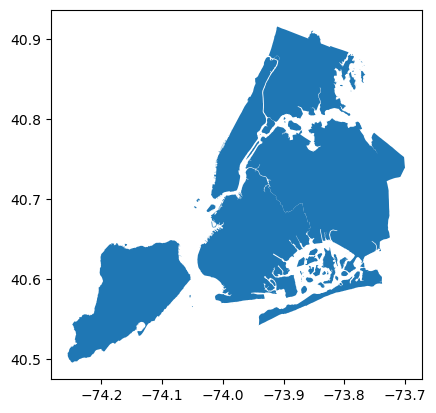

In [50]:
# Display
gdf.plot()

In [37]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, pandas_udf
def create_sjoin_udf(gdf_with_poly,join_column_name):
    def sjoin_settlement(x, y):
        gdf_temp = gpd.GeoDataFrame(data = [[x] for x in range(len(x))],geometry=gpd.points_from_xy(x,y),columns=['id'])
        settlement = gpd.sjoin(gdf_temp,gdf_with_poly,how='left',op='within')#.fillna(np.nan)
        return settlement.groupby('id').agg({'poly_ID':lambda x: list(x)}).reset_index().sort_values(by='id').loc[:,join_column_name].astype('str')# if pd.isnull(sum(x)) == False else np.nan}).reset_index().sort_values(by='id').loc[:,join_column_name]
    return pandas_udf(sjoin_settlement, returnType=StringType())
    
sjoin_udf = create_sjoin_udf(gdf,'poly_ID')

In [54]:
from pyspark.sql.functions import rand
import pandas as pd
n=1000

raw_data = spark.table(raw_table_name)
limit_raw_data=raw_data.select("pickup_longitude","pickup_latitude").orderBy(rand()).limit(n)
pandas_df = limit_raw_data.toPandas()

pandas_df = pandas_df.dropna(subset=["pickup_longitude", "pickup_latitude"])
# Create GeoDataFrame
geo_raw_data = gpd.GeoDataFrame(
    pandas_df, 
    geometry=[Point(xy) for xy in zip(pandas_df["pickup_longitude"], pandas_df["pickup_latitude"])]
)

<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

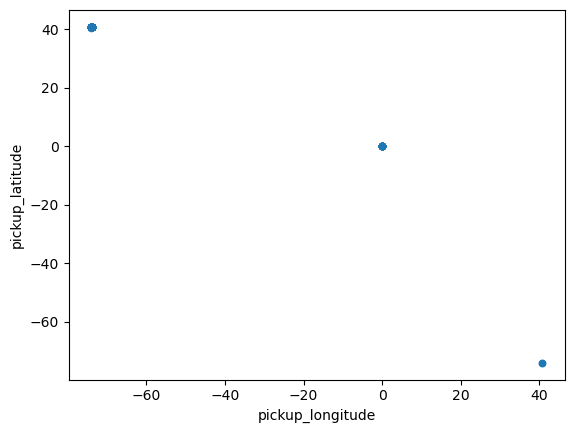

In [55]:
geo_raw_data.plot(
    kind='scatter', x="pickup_longitude", y="pickup_latitude"
)

In [57]:
geo_raw_data.head()

,pickup_longitude,pickup_latitude,geometry
0,-73.980904,40.774246,POINT (-73.98090 40.77425)
1,-73.986542,40.740200,POINT (-73.98654 40.74020)
2,-74.004677,40.752151,POINT (-74.00468 40.75215)
3,0.000000,0.000000,POINT (0.00000 0.00000)
4,-73.985649,40.750561,POINT (-73.98565 40.75056)


In [46]:
geo_data=raw_data.withColumn('poly_ID',sjoin_udf(raw_data.pickup_longitude,raw_data.pickup_latitude))

# 02 - Run the query

## 02.1 - Query 1

### 02.1.a Create function

In [28]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, ArrayType, LongType
# Create UDF for finding idle time between two times
def idle_time_ms(start_ms, prev_end_ms):
    if start_ms is None or prev_end_ms is None:
        return 0
    idle_ms = start_ms - prev_end_ms
    threshold_duration_ms = 4 * 60 * 60 * 1000  # 4 hours in milliseconds
    if idle_ms < 0 or idle_ms > threshold_duration_ms:
        return 0
    else:
        return idle_ms
    
# Define as UDF
spark.udf.register("idle_time_ms_udf",idle_time_ms, LongType())

<function __main__.idle_time_ms(start_ms, prev_end_ms)>

### 02.1.b - Build Query 1

In [29]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, unix_timestamp, sum, col, date_format,to_date
from datetime import datetime

# require variables
trip_data_bucketed = spark.table(raw_table_name)

# Configure the window

# Define the window specification with partitionBy and orderBy
window_conf = Window.partitionBy(col("medallion")).orderBy(col("pickup_date"), col("pickup_time"))
# Medallion refers to the vehicle, hack_license refers to the driver
window_conf = Window.partitionBy(col("medallion")).orderBy(col("pickup_date"),col("pickup_time"))

# TODO: Add shuffling here
#   ...
taxi_util_data = trip_data_bucketed
# Extract pickup_date and pickup_time from pickup_datetime
taxi_util_data = taxi_util_data.withColumn("pickup_date", to_date(col("pickup_datetime")))
taxi_util_data = taxi_util_data.withColumn("pickup_time", date_format(col("pickup_datetime"), "HH:mm:ss"))

# Add column with pickup datetime of previous
# NB! The default value for the lag might not be correct
taxi_util_data_sorted = taxi_util_data.withColumn("dropoff_datetime_prev", lag(col("dropoff_datetime"), default=datetime.min).over(window_conf))

# Convert to timestamp
taxi_util_data_sorted_ts = taxi_util_data_sorted.withColumn("pickup_ts_ms", unix_timestamp("pickup_datetime") * 1000) \
    .withColumn("dropoff_prev_ts_ms", unix_timestamp("dropoff_datetime_prev") * 1000)

# Calculate idle time per ride
taxi_util_data_idle = taxi_util_data_sorted_ts.withColumn("idle_time_ms", idle_time_ms_udf("pickup_ts_ms", "dropoff_prev_ts_ms"))

# Calculate total idle time per taxi
taxi_util_data_idle_total = taxi_util_data_idle.groupBy(col("medallion")).agg(sum(col("idle_time_ms")))

### 02.1.c - Display Query1

In [30]:
spark.sql("DROP TABLE IF EXISTS "+query1_table_name)
taxi_util_data_idle_total.write\
    .format("parquet")\
    .bucketBy(bucket_count,column_partitioner)\
    .mode("append")\
    .saveAsTable(query1_table_name)

In [31]:
query1_data = spark.table(query1_table_name)
print("Number of records in table: ",query1_data.count())
query1_data.show()

Number of records in table:  14144
+--------------------+-----------------+
|           medallion|sum(idle_time_ms)|
+--------------------+-----------------+
|0220580F4DB64D175...|        202620000|
|0293108C734F9B1C3...|      12092040000|
|04C5991FD21FBCA6F...|       9339794000|
|0925ACE65D2B99A29...|      10862520000|
|10173154AB7597AAA...|      13198140000|
|1855E1F1B1D92297C...|       8546340000|
|2452625B674098557...|      12695940000|
|24D43849571D12D4E...|       5866373000|
|25D566E299C678396...|      14408970000|
|281BD3C8825FF093D...|       6432812000|
|3020BDF11FA1B155D...|      10911360000|
|302EB02F36343A64C...|      13360262000|
|343B4F963805B642F...|       9356340000|
|3C4E85EE0BACAD3A7...|       3465610000|
|55926285A4B50F996...|      11144460000|
|576BE3CE0F330A86C...|      10355820000|
|584FBA783588D4533...|       5736660000|
|6C7CB6AF6A0C533AB...|      14506573000|
|70A5A3A78A693F834...|       6489420000|
|78FD0655D0CBD598C...|       8836740000|
+--------------------+

# Query 2 - Average idle time per borough

# Query 3 - The number of trips that started and ended within the same borough

# Query 4 -  The number of trips that started in one borough and ended in another one